In [26]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [27]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
print(tf.__version__)

2.10.0


In [28]:
# Create a list with the filepaths for training and testing
train_dir = Path('dataset/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

In [29]:
test_dir = Path('dataset/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [30]:
val_dir = Path('dataset/val')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [31]:
print(len(train_filepaths))
print(len(test_filepaths))
print(len(val_filepaths))

2855
340
340


In [45]:
def image_processing(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """
    
    labels = [str(filepath[i]).split("\\")[-2] for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [46]:

train_df = image_processing(train_filepaths)

test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

In [34]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 2855

Number of different labels: 2855

Labels: ['dataset\\train\\raddish\\Image_2.jpg'
 'dataset\\train\\banana\\Image_86.jpg'
 'dataset\\train\\corn\\Image_54.jpg' ...
 'dataset\\train\\peas\\Image_21.jpg'
 'dataset\\train\\beetroot\\Image_65.jpg'
 'dataset\\train\\watermelon\\Image_29.jpg']


In [47]:
train_df.head(5)

,Filepath,Label
0,dataset\train\onion\Image_11.jpg,onion
1,dataset\train\turnip\Image_76.jpg,turnip
2,dataset\train\capsicum\Image_93.jpg,capsicum
3,dataset\train\cauliflower\Image_77.jpg,cauliflower
4,dataset\train\turnip\Image_84.jpg,turnip


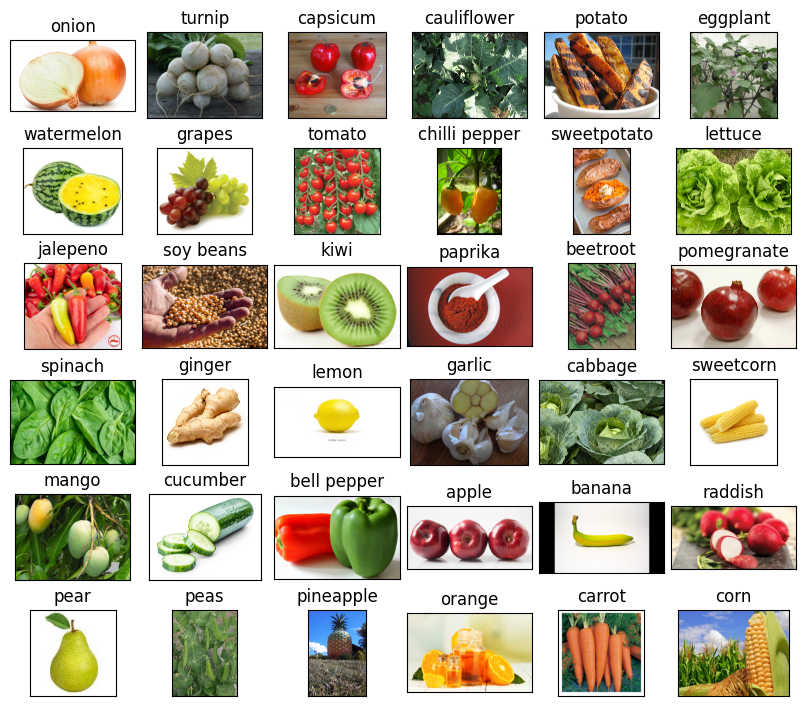

In [48]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [49]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [50]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 2855 validated image filenames belonging to 36 classes.


In [51]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 340 validated image filenames belonging to 36 classes.


In [52]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 340 validated image filenames belonging to 36 classes.


In [53]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [54]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
90/90 [==============================] - 75s 795ms/step - loss: 1.7734 - accuracy: 0.5331 - val_loss: 0.4770 - val_accuracy: 0.8735
Epoch 2/5
90/90 [==============================] - 65s 726ms/step - loss: 0.5753 - accuracy: 0.8126 - val_loss: 0.3328 - val_accuracy: 0.9029
Epoch 3/5
90/90 [==============================] - 66s 733ms/step - loss: 0.3457 - accuracy: 0.8900 - val_loss: 0.3048 - val_accuracy: 0.9235
Epoch 4/5
90/90 [==============================] - 65s 728ms/step - loss: 0.2237 - accuracy: 0.9338 - val_loss: 0.2597 - val_accuracy: 0.9324
Epoch 5/5
90/90 [==============================] - 66s 730ms/step - loss: 0.1498 - accuracy: 0.9576 - val_loss: 0.2043 - val_accuracy: 0.9647


In [56]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

11/11 [==============================] - 9s 794ms/step


['cucumber',
 'cabbage',
 'pineapple',
 'garlic',
 'beetroot',
 'onion',
 'sweetcorn',
 'pineapple',
 'paprika',
 'sweetpotato',
 'garlic',
 'bell pepper',
 'kiwi',
 'sweetpotato',
 'corn',
 'apple',
 'ginger',
 'peas',
 'grapes',
 'pomegranate',
 'capsicum',
 'cauliflower',
 'ginger',
 'corn',
 'carrot',
 'apple',
 'spinach',
 'tomato',
 'corn',
 'cabbage',
 'paprika',
 'sweetpotato',
 'apple',
 'raddish',
 'garlic',
 'cauliflower',
 'bell pepper',
 'ginger',
 'carrot',
 'grapes',
 'mango',
 'banana',
 'kiwi',
 'potato',
 'pear',
 'eggplant',
 'jalepeno',
 'corn',
 'garlic',
 'kiwi',
 'banana',
 'cucumber',
 'tomato',
 'bell pepper',
 'cauliflower',
 'jalepeno',
 'pear',
 'pear',
 'watermelon',
 'paprika',
 'turnip',
 'cucumber',
 'soy beans',
 'soy beans',
 'chilli pepper',
 'potato',
 'cucumber',
 'capsicum',
 'peas',
 'mango',
 'pineapple',
 'mango',
 'turnip',
 'potato',
 'cabbage',
 'tomato',
 'cauliflower',
 'paprika',
 'tomato',
 'spinach',
 'pineapple',
 'grapes',
 'orange',
 

In [59]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [66]:
img = output('download.jpeg')
img

1/1 [==============================] - 0s 31ms/step


'cabbage'

In [ ]:
model.save('FV.h5')